In [11]:
import numpy as np
import sys
import os
from tqdm import tqdm # loading bar
from helpers.utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, extend_alignment, Tree, convert_to_desired_format2,convert_format_mat_to_pseudomat,find_min_span_edges,get_visiting_order
from sp_approx_modified import compute_cost


matrix_for_MST=[]

def sp_approxi(seqs: list[str], score_matrix: dict, gap_cost: int, verbose=False, return_center_string=False):
    # STEP 1: Find the center string, s1
    matrix = np.full((len(seqs), len(seqs)), np.nan)
    # loop over all distinct pairs
    for i, seq1 in enumerate(seqs):
        for j, seq2 in enumerate(seqs):
              matrix[i, j] = get_cost_2(linear_C(gap_cost, score_matrix, seq1, seq2))
    print(matrix)
    matrix_for_MST=matrix 
    matrix_for_MST=convert_to_desired_format2(matrix_for_MST)
    min_span_edges=find_min_span_edges(matrix_for_MST)
    print(matrix_for_MST)
    print(min_span_edges)
    visiting_order=get_visiting_order(min_span_edges,"A") #A needs to be substituted at some point
    print(visiting_order) #visiting order is now letters, but we would need that as numbers/idices from the score matrix to keep track. #APPARENTLY NOT ACTUALLY IN USE

    # find center string/guide 
    s1_idx = np.argmin(matrix.sum(axis = 1))
    s1 = seqs[s1_idx]
    seqs.insert(0, seqs.pop(s1_idx)) # move guide to front of list
    if verbose: print("The center string, s1, is sequence no." + str(s1_idx+1)) # just a print statement to see which string is the center string

    # STEP 2: Construct alignment M
    M: list[list[str]] = [[letter] for letter in [*s1]]
    print("M right now:")
    print(M)
    print("s1 right now:")
    print(s1)
    cost_list = []
    # print("first M = \n" + str(M))
    for i in range(1, len(seqs)):
        # if i == s1_idx: # skip the guide 
        #    continue
        cost = linear_C(gap_cost, score_matrix, s1, seqs[i])
        cost_list.append(get_cost_2(cost))
        
        # prepare A-matrix for extension
        alignment1_str, alignment2_str = linear_backtrack(s1, seqs[i], cost, score_matrix, gap_cost)
        alignment1, alignment2 = [*alignment1_str], [*alignment2_str]
        A = [list(e) for e in zip(alignment1,alignment2)]
        
        # extend
        Mk = extend_alignment(M, A)
        M = Mk
    
    # ACTUALLY COMPUTE (approximate) COST
    total_cost = compute_cost(M, score_matrix, gap_cost)
    
    if return_center_string: return total_cost, M, s1_idx
    return total_cost, M, matrix_for_MST, visiting_order

[[ 0.  5.  7. 12.]
 [ 5.  0. 10. 17.]
 [ 7. 10.  0.  7.]
 [12. 17.  7.  0.]]
[['' '5' 'A' 'B']
 ['' '7' 'A' 'C']
 ['' '12' 'A' 'D']
 ['' '10' 'B' 'C']
 ['' '17' 'B' 'D']
 ['' '7' 'C' 'D']]
[['*' '5' 'A' 'B']
 ['*' '7' 'A' 'C']
 ['*' '7' 'C' 'D']
 ['' '10' 'B' 'C']
 ['' '12' 'A' 'D']
 ['' '17' 'B' 'D']]


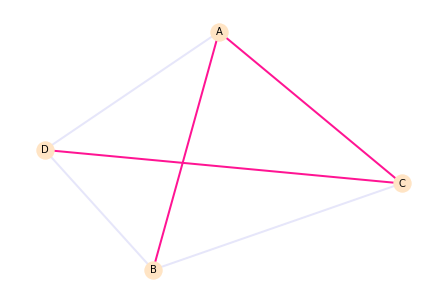

['A', 'B', 'C', 'D']
M right now:
[['a'], ['t'], ['c']]
s1 right now:
atc


(75,
 [['a', 'a', 'a', 'g'],
  ['-', 't', '-', '-'],
  ['t', 't', 'g', 'g'],
  ['c', 'c', 't', 'a']],
 array([['', '5', 'A', 'B'],
        ['', '7', 'A', 'C'],
        ['', '12', 'A', 'D'],
        ['', '10', 'B', 'C'],
        ['', '17', 'B', 'D'],
        ['', '7', 'C', 'D']], dtype='<U11'),
 ['A', 'B', 'C', 'D'])

In [12]:
seqs=["atc","attc","agt","gga"]
score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=5
sp_approxi(seqs,score_matrix,gap_cost)

